## Climate Policies Under Wealth Inequality
This notebook is meant to reproduce the results shown in the paper "Climate policies under wealth inequality", linked here: https://www.pnas.org/doi/10.1073/pnas.1323479111. 

#### Abstract of the paper:
(verbatim) Taming the planet’s climate requires cooperation. Previous failures to reach consensus in climate summits have been attributed, among other factors, to conflicting policies between rich and poor countries, which disagree on the implementation of mitigation measures. Here we implement wealth inequality in a threshold public goods dilemma of cooperation in which players also face the risk of potential future losses. We consider a population exhibiting an asymmetric distribution of rich and poor players that reflects the present-day status of nations and study the behavioral interplay between rich and poor in time, regarding their willingness to cooperate. Individuals are also allowed to exhibit a variable degree of homophily, which acts to limit those that constitute one’s sphere of influence. Under the premises of our model, and in the absence of homophily, comparison between scenarios with wealth inequality and without wealth inequality shows that the former leads to more global cooperation than the latter. Furthermore, we find that the rich generally contribute more than the poor and will often compensate for the lower contribution of the latter. Contributions from the poor, which are crucial to overcome the climate change dilemma, are shown to be very sensitive to homophily, which, if prevalent, can lead to a collapse of their overall contribution. In such cases, however, we also find that obstinate cooperative behavior by a few poor may largely compensate for homophilic behavior.

To achieve the results of the paper, we have created a Public Goods Game (PGG) to model the climate policies game.

In [1]:
#!pip install egttools numpy matplotlib > /dev/null 2>&1

Questions:
1. Is it possible to use AbstractNPlayerGame - even though it doesn't directly provide functions to split populations into two distint groups with different behaviors?
2. Should we be drawing up a payoff matrix? Can it really capture the subtleties of this model?
3. Can we use PairwiseComparison - given our use case needs to be evolved using custom methods, based on homophily and "obstinate" mutations.
4. Can a simplex be drawn with just two axis/two populations using plot_replicator_dynamics_in_simplex? I think not, but checking if there is another way?
5. PairwiseComparison/PairwiseComparisonNumerical all consider movement between population states, but we can't allow rich <-> poor transitions!

In [73]:
import numpy as np
import random
import matplotlib.pyplot as plt
from math import comb

class ThresholdPublicGoodsGame:
    def __init__(self, 
                 population_size, #200
                 rich_fraction, #20%
                 endowment_rich, #2.5
                 endowment_poor,  #0.625
                 group_size, 
                 threshold,
                 risk,
                 contribution_factor, #0.1
                 homophily):
        self.population_size = population_size
        self.rich_fraction = rich_fraction
        self.endowment_rich = endowment_rich
        self.endowment_poor = endowment_poor
        self.group_size = group_size
        self.threshold = threshold
        self.risk = risk
        self.contribution_factor = contribution_factor
        self.homophily = homophily

        self.num_rich = int(rich_fraction * population_size)
        self.num_poor = population_size - self.num_rich

        # Average endowment is used to calculate the threshold for success
        self.average_endowment = (self.num_rich * endowment_rich + self.num_poor * endowment_poor) / population_size
        
        self.init_new_random_population()
        
    def init_new_random_population(self):
        # Initialize population with strategies (1 = cooperator, 0 = defector)
        # Strategies are assigned randomly!
        self.population = {
            "rich": [random.choice([0, 1]) for _ in range(self.num_rich)],
            "poor": [random.choice([0, 1]) for _ in range(self.num_poor)]
        }
    
    def play_group(self, group):
        contributions = sum(
            self.contribution_factor * (self.endowment_rich if is_rich else self.endowment_poor)
            for is_rich, strategy in group if strategy == 1 # Strategy = 1 means C, Ds don't contribute
        )
        required_contribution = self.threshold * self.contribution_factor * self.average_endowment
        #print("contributions, required_contribution", contributions, required_contribution)
        return contributions >= required_contribution

    def pairwise_comparison(self, fitness_a, fitness_b, strategy_a, strategy_b, beta=3.0):
        # Fermi function to calculate probability of adopting strategy B
        prob = 1 / (1 + np.exp(-beta * (fitness_b - fitness_a)))

        # print(f"Fitness A: {fitness_a}, Fitness B: {fitness_b}, Prob: {prob}")
        # print(f"Strategy A Before: {strategy_a}, After: {strategy_b if random.random() < prob else strategy_a}")
        
        # Decide whether to adopt strategy B
        if random.random() < prob:
            return strategy_b  # Adopt strategy B
        return strategy_a  # Keep strategy A

    def form_groups(self):
        self.init_new_random_population()

        # Here True means rich and False means poor, strat = C or D (1 or 0)
        mixed_population = [(True, strat) for strat in self.population["rich"]] + \
                       [(False, strat) for strat in self.population["poor"]]

        # Shuffle the group and create "segments" from this random distribution - everyone plays!
        random.shuffle(mixed_population)
        self.groups = [mixed_population[i:i + self.group_size] 
                  for i in range(0, len(mixed_population), self.group_size)]

        # for group in self.groups:
        #     print(group)

    def calculate_fitness(self):
        # Initialize fitness values for all individuals
        fitness_rich = [0.0] * self.num_rich
        fitness_poor = [0.0] * self.num_poor
        participation_count_rich = [0] * self.num_rich
        participation_count_poor = [0] * self.num_poor
    
        # Iterate through all groups
        for group in self.groups:
            # Determine group success
            success = self.play_group(group)
            catastrophe = random.random() < self.risk  # Determine if catastrophe occurs
            
            # Calculate payoffs for each individual in the group
            for i, (is_rich, strategy) in enumerate(group):
                # Determine individual-specific values
                endowment = self.endowment_rich if is_rich else self.endowment_poor
                contribution = self.contribution_factor * endowment if strategy == 1 else 0  # Only cooperators contribute
                payoff = endowment - contribution
    
                # Apply penalty if group fails and catastrophe occurs
                if not success and catastrophe:
                    payoff *= (1 - self.risk)
    
                # Update fitness and participation count
                if is_rich:
                    index = self.population["rich"].index(strategy)  # Get the individual's index
                    fitness_rich[index] += payoff
                    participation_count_rich[index] += 1
                else:
                    index = self.population["poor"].index(strategy)  # Get the individual's index
                    fitness_poor[index] += payoff
                    participation_count_poor[index] += 1
    
        # Normalize fitness by the number of groups participated in
        fitness_rich = [
            fitness / count if count > 0 else 0.0
            for fitness, count in zip(fitness_rich, participation_count_rich)
        ]
        fitness_poor = [
            fitness / count if count > 0 else 0.0
            for fitness, count in zip(fitness_poor, participation_count_poor)
        ]
    
        return fitness_rich, fitness_poor

    def simulate_round(self):
        group_results = []
    
        # Calculate fitness for the entire population based on the current state
        fitness_rich, fitness_poor = self.calculate_fitness()
    
        # Iterate through groups
        for group in self.groups:
            # Compute contributions and determine group success
            success = self.play_group(group)
            group_results.append(success)
    
            # Perform pairwise comparison for each individual in the group
            for i, (is_rich, strategy_a) in enumerate(group):
                # Get fitness based on wealth class
                if is_rich:
                    fitness_a = fitness_rich[self.population["rich"].index(strategy_a)]
                else:
                    fitness_a = fitness_poor[self.population["poor"].index(strategy_a)]
    
                # Select another individual in the group, respecting homophily
                if random.random() < self.homophily:
                    candidates = [j for j, (r, _) in enumerate(group) if r == is_rich and j != i]
                else:
                    candidates = [j for j in range(len(group)) if j != i]
    
                if not candidates:
                    continue  # No candidates to compare with
                
                j = random.choice(candidates)
                _, strategy_b = group[j]
    
                # Get fitness of candidate
                if group[j][0]:  # Is rich
                    fitness_b = fitness_rich[self.population["rich"].index(strategy_b)]
                else:
                    fitness_b = fitness_poor[self.population["poor"].index(strategy_b)]
    
                # Update strategy based on pairwise comparison
                group[i] = (is_rich, self.pairwise_comparison(fitness_a, fitness_b, strategy_a, strategy_b))
    
            # Mutation step: Randomly flip strategy with a small probability
            mutation_prob = 0.01  # Mutation probability
            for i, (is_rich, strategy) in enumerate(group):
                if random.random() < mutation_prob:
                    group[i] = (is_rich, 1 - strategy)  # Flip strategy
    
        return group_results


    def simulate(self, rounds=10):
        results = []
        self.form_groups()

        for _ in range(rounds):
            group_results = self.simulate_round()
            #payoffs = self.calculate_payoffs(group_results)
            results.append({
                "group_results": group_results
                #"payoffs": payoffs
            })
        #print("results", results)
        return results

    def compute_eta_g(self, risk, homophily, rounds=500):
        self.risk = risk
        self.homophily = homophily
        group_success_rates = []
        self.form_groups()

        for _ in range(rounds):
            group_results = self.simulate_round()
            success_rate = sum(group_results) / len(group_results)  # Fraction of successful groups
            group_success_rates.append(success_rate)
        
        eta_g = np.mean(group_success_rates)
        #print("group_success_rates, eta_g", group_success_rates, eta_g)
        return eta_g


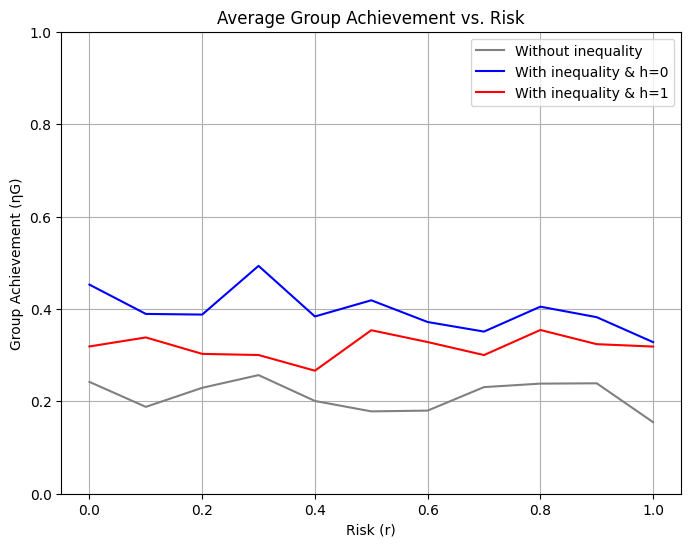

In [76]:
# Parameters
population_size = 200
rich_fraction = 0.2
endowment_rich = 2.5
endowment_poor = 0.625
group_size = 6
threshold = 3
contribution_factor = 0.1
risk = 0.1
homophily = 0.2

# Create the game instance
game = ThresholdPublicGoodsGame(
    population_size, rich_fraction, endowment_rich, endowment_poor,
    group_size, threshold, risk, contribution_factor, homophily
)

# Range of risk values
risks = np.linspace(0, 1, 11)

# Compute group achievement for each scenario
eta_no_inequality = []
eta_with_inequality_h0 = []
eta_with_inequality_h1 = []

# Case 1: No inequality
game.endowment_rich = 1
game.endowment_poor = 1
for r in risks:
    eta_no_inequality.append(game.compute_eta_g(risk, homophily))

# Case 2: With inequality, homophily = 0
game.endowment_rich = 2.5
game.endowment_poor = 0.625
homophily = 0.1
for r in risks:
    eta_with_inequality_h0.append(game.compute_eta_g(risk, homophily))

# Case 3: With inequality, homophily = 1
homophily = 0.9
for r in risks:
    eta_with_inequality_h1.append(game.compute_eta_g(risk, homophily))

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(risks, eta_no_inequality, label="Without inequality", color="gray")
plt.plot(risks, eta_with_inequality_h0, label="With inequality & h=0", color="blue")
plt.plot(risks, eta_with_inequality_h1, label="With inequality & h=1", color="red")
plt.xlabel("Risk (r)")
plt.ylabel("Group Achievement (ηG)")
plt.title("Average Group Achievement vs. Risk")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()